In [1]:
# Mutation Simulation experiments for same genome

# Author Fraser Toon

In [2]:
# Imports needed
import os
import subprocess
import helpers
import pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import numpy

In [3]:
# Number of genomes for the test: 384
# Filters are:
# Type: Escherichia
# Length: Complete
# Year: 2024-2024
# Condition (?): Annotated

In [4]:
# Specify the starting directory
start_directory = '/home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data'

# Arrays to hold directories and file names
directories = []
file_names = []

# Traverse the directory tree
for root, dirs, files in os.walk(start_directory):
    for file in files:
        if file.endswith('genomic.fna') and "SNP" not in file:
            directories.append(root)
            file_names.append(file)

print(f"Done: {len(directories), len(file_names)}")


Done: (384, 384)


In [4]:
index = 0
rate = [0.05]
for SNP_rate in rate:
    if directories and file_names:
        for first_directory, first_fna_file in zip(directories, file_names):
            index = index + 1
            print(f'{index}: {first_directory} -> {first_fna_file}')

            # Build the command to change directory and show the first 10 lines of the .fna fil
            command = f'cd {first_directory} && (/usr/bin/time -v mutation-simulator {first_fna_file} args -sn {SNP_rate} && mv $(find . -name "*.fna" | grep -vi "_gen" | grep -vi "SNP") SNP_{SNP_rate}_{first_fna_file} && mv $(find . -name "*.fna.fai" | grep -vi "SNP") SNP_{SNP_rate}_{first_fna_file}.fai)  > stats.txt 2>&1'

            try:
                # Run the command in the shell with a timeout of 3 minutes
                result = subprocess.run(command, shell=True, timeout=3*60, stderr=subprocess.PIPE, universal_newlines=True)

                # Print stderr output
                if result.stderr:
                    print(result.stderr)
                
            except subprocess.TimeoutExpired as e:
                print(f"Command timed out: {e}")
            except Exception as e:
                print(f"An error occurred: {e}")
    else:
        print("No .fna files found.")
print("Done")

1: /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_036884635.1 -> GCF_036884635.1_ASM3688463v1_genomic.fna
2: /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_036884625.1 -> GCF_036884625.1_ASM3688462v1_genomic.fna
3: /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_039912475.1 -> GCF_039912475.1_ASM3991247v1_genomic.fna
4: /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_036923505.1 -> GCF_036923505.1_STEC28_genomic.fna
5: /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_037914955.1 -> GCF_037914955.1_pKPC_NDMdeltaNDM_genomic.fna
6: /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_039912655.1 -> GCF_039912655.1_ASM3991265v1_genomic.fna
7: /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_039583295.1 -> GCF_039583295.1_ASM3958329v1_genomic.fna
8: /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_964053065.1 -> GCF_964053065.1_30859_5_287_genomic.fna
9: /home/ftoon/Tests/TestingDatasets/ncbi_d

In [5]:
# Make full path of original files
index = 0
original_genomes = []
if directories and file_names:
    for first_directory, first_fna_file in zip(directories, file_names):
        file_location = first_directory + "/" + first_fna_file
        original_genomes.append(file_location)
        index = index + 1

else:
    print("No .fna files found.")

print(f"Done: {len(original_genomes)}")
print(f"{original_genomes[0]}")

Done: 384
/home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_036884635.1/GCF_036884635.1_ASM3688463v1_genomic.fna


In [6]:
# Get paths of new genomes
# See if there has been a 5% change in each, get length of orginal, length of change and difference value between them.ls
new_genomes = []
end_pattern = ".fna"
mod_patterns = ["0.05"]
bad_pattern = ".fai"

# Traverse the directory tree
for root, dirs, files in os.walk(start_directory):
    for file in files:
        if end_pattern in file and any(mod_pattern in file for mod_pattern in mod_patterns) and bad_pattern not in file:
            new_genomes.append(str(root) + "/" + str(file))


print(f"Done: {len(new_genomes)}")
print(f"{new_genomes[0]}")

Done: 384
/home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_036884635.1/SNP_0.05_GCF_036884635.1_ASM3688463v1_genomic.fna


In [7]:
time_array = []
max_resident_size_array = []

for file_path in directories:
    if not os.path.isfile(file_path + "/stats.txt"):
        print(f"The file at {file_path} does not exist.")
        continue

    try:
        with open(file_path + "/stats.txt", 'r') as file:
            found_time = False
            found_max_res = False

            for line in file:
                if not found_time:
                    time_match = re.search(r'Mutation-Simulator finished in: ([\d.]+)s', line)
                    if time_match:
                        time_taken = time_match.group(1)
                        time_array.append(float(time_taken))
                        found_time = True

                if not found_max_res:
                    max_res_match = re.search(r'Maximum resident set size \(kbytes\): (\d+)', line)
                    if max_res_match:
                        max_resident_size = max_res_match.group(1)
                        max_resident_size_array.append(int(max_resident_size))
                        found_max_res = True

                if found_time and found_max_res:
                    break

            if not found_time:
                print(f"No simulation time found in the file: {file_path}")
            if not found_max_res:
                print(f"No maximum resident set size found in the file: {file_path}")
                
    except Exception as e:
        print(f"An error occurred while processing the file {file_path}: {e}")

print(f"Time array: {len(time_array)}")
print(f"Maximum resident size array: {len(max_resident_size_array)}")

print(f"T: {time_array[0]}, M: {max_resident_size_array[0]}")

Time array: 384
Maximum resident size array: 384
T: 8.8129, M: 143572


In [8]:
# Array to hold file sizes
file_sizes = []

for file_path in original_genomes:
    try:
        # Get the file size
        file_size = os.path.getsize(file_path)
        # Append the file size to the array
        file_sizes.append(file_size)
    except OSError as e:
        # If there's an error (e.g., file doesn't exist), append None and print an error message
        file_sizes.append(None)
        print(f"Error accessing file {file_path}: {e}")

# Print the array with file sizes
print("File sizes:", len(file_sizes))

File sizes: 384


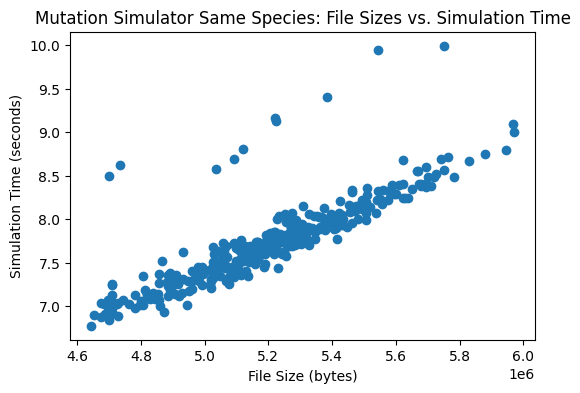

In [13]:
# Plotting time against genome size
# Convert file paths to a simple numeric index for x-axis
x = file_sizes
y = time_array

plt.figure(figsize=(6, 4))  # Set the figure size (width, height)
plt.scatter(x, y)
plt.title('Mutation Simulator Same Species: File Sizes vs. Simulation Time')
plt.xlabel('File Size (bytes)')
plt.ylabel('Simulation Time (seconds)')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.show()

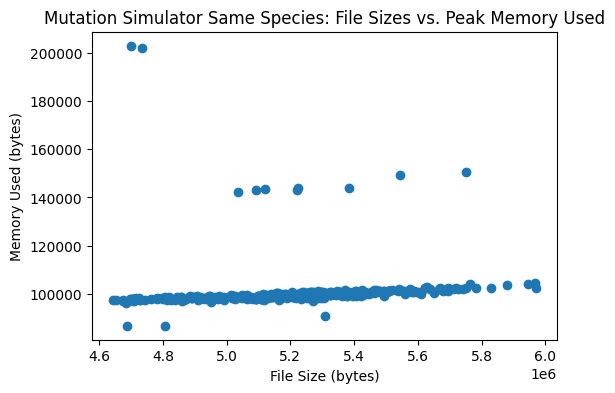

In [14]:
# Plotting memory against genome size
# Convert file paths to a simple numeric index for x-axis
x = file_sizes
y = max_resident_size_array

plt.figure(figsize=(6, 4))  # Set the figure size (width, height)
plt.scatter(x, y)
plt.title('Mutation Simulator Same Species: File Sizes vs. Peak Memory Used')
plt.xlabel('File Size (bytes)')
plt.ylabel('Memory Used (bytes)')
plt.show()

In [11]:
# Running ANI Tests
for i in range(len(directories)):
    file_paths = [original_genomes[i], new_genomes[i]]

    #print(f"{i}\nDr: {directories[i]}\nOG: {original_genomes[i]}\nNG: {new_genomes[i]}")


    # Process each file in the file_paths list
    command = f'cd {directories[i]} && /opt/FastANI-v1.34/fastANI -r {file_paths[0]} -q {file_paths[1]} -o {directories[i]}/fastani.txt'
    try:
        # Run the command in the shell with a timeout of 3 minutes
        result = subprocess.run(command, shell=True, timeout=3*60, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, universal_newlines=True)

        # Print stderr output
        if result.stderr:
            print(result.stderr)
                
    except subprocess.TimeoutExpired as e:
        print(f"Command timed out: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [16]:
# Arrays to store ANI values and other related information
ani_values_array = []

for file_path in directories:
    fastani_file = os.path.join(file_path, "fastani.txt")
    if not os.path.isfile(fastani_file):
        print(f"The file at {fastani_file} does not exist.")
        continue

    try:
        with open(fastani_file, 'r') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) >= 3:
                    try:
                        ani_value = float(parts[2])
                        ani_values_array.append(ani_value)
                    except ValueError:
                        print(f"Could not convert ANI value to float: {parts[2]}")
                
    except Exception as e:
        print(f"An error occurred while processing the file {fastani_file}: {e}")

print(f"ANI values array length: {len(ani_values_array)}")
if ani_values_array:
    print(f"First ANI value: {ani_values_array[0]}")

ANI values array length: 384
First ANI value: 94.1656


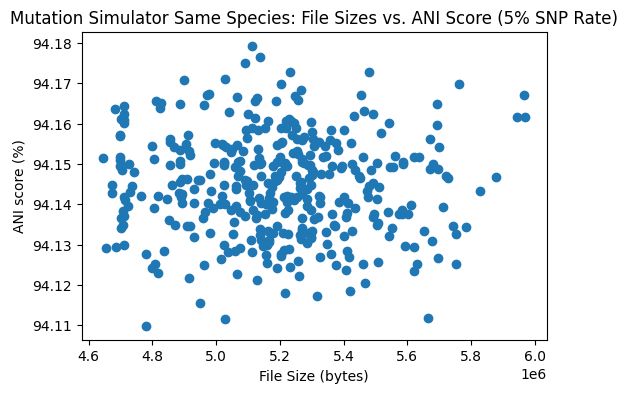

In [17]:
# Plotting time against genome size
# Convert file paths to a simple numeric index for x-axis
x = file_sizes
y = ani_values_array

plt.figure(figsize=(6, 4))  # Set the figure size (width, height)
plt.scatter(x, y)
plt.title('Mutation Simulator Same Species: File Sizes vs. ANI Score (5% SNP Rate)')
plt.xlabel('File Size (bytes)')
plt.ylabel('ANI score (%)')
plt.show()

ANI Scores Statistics:
Mean: 94.14464140625
Median: 94.14485
Standard Deviation: 0.012475228751307908
Min: 94.1099
Max: 94.1793
Range: 0.06940000000000168


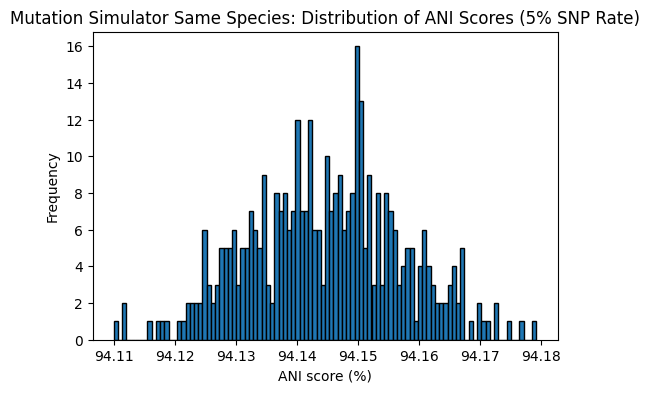

In [19]:
# Your existing data
x = file_sizes
y = ani_values_arrayy = numpy.array(ani_values_array)
ani_mean = numpy.mean(y)
ani_median = numpy.median(y)
ani_std = numpy.std(y)
ani_min = numpy.min(y)
ani_max = numpy.max(y)
ani_range = ani_max - ani_min
print("ANI Scores Statistics:")
print(f"Mean: {ani_mean}")
print(f"Median: {ani_median}")
print(f"Standard Deviation: {ani_std}")
print(f"Min: {ani_min}")
print(f"Max: {ani_max}")
print(f"Range: {ani_range}")

plt.figure(figsize=(6, 4))  # Set the figure size (width, height)

# Create a histogram of the ANI scores
plt.hist(y, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Mutation Simulator Same Species: Distribution of ANI Scores (5% SNP Rate)')
plt.xlabel('ANI score (%)')
plt.ylabel('Frequency')
plt.show()


In [20]:
y = numpy.array(ani_values_array)
ani_mean = numpy.mean(y)
ani_median = numpy.median(y)
ani_std = numpy.std(y)
ani_min = numpy.min(y)
ani_max = numpy.max(y)
ani_range = ani_max - ani_min
print("ANI Scores Statistics:")
print(f"Mean: {ani_mean}")
print(f"Median: {ani_median}")
print(f"Standard Deviation: {ani_std}")
print(f"Min: {ani_min}")
print(f"Max: {ani_max}")
print(f"Range: {ani_range}")

ANI Scores Statistics:
Mean: 94.14464140625
Median: 94.14485
Standard Deviation: 0.012475228751307908
Min: 94.1099
Max: 94.1793
Range: 0.06940000000000168


In [16]:
# Create simulations at different rates
index = 0
rate = [0.01,0.02,0.03,0.04,0.06,0.07,0.08,0.09,0.10] # Already have done 0.05
for SNP_rate in rate:
    if directories and file_names:
        count = 0  # Counter for directories processed
        for first_directory, first_fna_file in zip(directories, file_names):
            if count >= 10:  # Check if 10 directories have been processed
                break

            index = index + 1
            print(f'{index}: {SNP_rate}) {first_directory} -> {first_fna_file}')

            # Build the command to change directory and show the first 10 lines of the .fna file
            command = f'cd {first_directory} && (/usr/bin/time -v mutation-simulator {first_fna_file} args -sn {SNP_rate} && mv $(find . -name "*.fna" | grep -vi "_gen" | grep -vi "SNP") SNP_{SNP_rate}_{first_fna_file} && mv $(find . -name "*.fna.fai" | grep -vi "SNP") SNP_{SNP_rate}_{first_fna_file}.fai) > stats.txt 2>&1'

            try:
                # Run the command in the shell with a timeout of 3 minutes
                result = subprocess.run(command, shell=True, timeout=3*60, stderr=subprocess.PIPE, universal_newlines=True)

                # Print stderr output
                if result.stderr:
                    print(result.stderr)
                
            except subprocess.TimeoutExpired as e:
                print(f"Command timed out: {e}")
            except Exception as e:
                print(f"An error occurred: {e}")

            count += 1  # Increment the counter after processing a directory
    else:
        print("No .fna files found.")
print("Done")


1: 0.01) /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_036884635.1 -> GCF_036884635.1_ASM3688463v1_genomic.fna
2: 0.01) /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_036884625.1 -> GCF_036884625.1_ASM3688462v1_genomic.fna
3: 0.01) /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_039912475.1 -> GCF_039912475.1_ASM3991247v1_genomic.fna
4: 0.01) /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_036923505.1 -> GCF_036923505.1_STEC28_genomic.fna
5: 0.01) /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_037914955.1 -> GCF_037914955.1_pKPC_NDMdeltaNDM_genomic.fna
6: 0.01) /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_039912655.1 -> GCF_039912655.1_ASM3991265v1_genomic.fna
7: 0.01) /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_039583295.1 -> GCF_039583295.1_ASM3958329v1_genomic.fna
8: 0.01) /home/ftoon/Tests/TestingDatasets/ncbi_dataset_same/data/GCF_964053065.1 -> GCF_964053065.1_30859_5_287_genomic

In [21]:
# Get paths of new genomes
# See if there has been a 5% change in each, get length of orginal, length of change and difference value between them.ls
ani_genomes = []
end_pattern = ".fna"
mod_patterns = ["SNP_0.01", "SNP_0.02", "SNP_0.03", "SNP_0.04", "SNP_0.05", "SNP_0.06", "SNP_0.07", "SNP_0.08", "SNP_0.09", "SNP_0.1"]
bad_pattern = ".fai"

directory_count = 0
for root, dirs, files in os.walk(start_directory):
    if directory_count > 10:  # Stop after checking 10 directories
        break
    
    for file in files:
        if end_pattern in file and any(mod_pattern in file for mod_pattern in mod_patterns) and bad_pattern not in file:
            ani_genomes.append(os.path.join(root, file))

    directory_count += 1

print(len(ani_genomes))

100


In [19]:
# Dont remember why this is here \_(._.)_/ <- I do remember, it runs the new ANI tests against the new SNP rates

# Extract the SNP_0.01 pattern 
for file_path in ani_genomes:

    # Figure out which number it is
    snp_pattern = re.search(r'SNP_\d+\.\d+', file_path)
    if snp_pattern:
        snp_full = snp_pattern.group(0)
    
        # Extract the numeric value from the SNP_0.01 pattern
        snp_value = re.search(r'\d+\.\d+', snp_full)
        if snp_value:
            snp_numeric = snp_value.group(0)

    # Get the OG dir
    og_dir = re.split(r'SNP_', file_path)[0]

    # Get the OG file
    matching_path = None
    for path in original_genomes:
        if path.startswith(og_dir):
            matching_path = path
            break

    command = f'cd {og_dir} && /opt/FastANI-v1.34/fastANI -r {matching_path} -q {file_path} -o {og_dir}/{snp_numeric}_fastani.txt'
    try:
        # Run the command in the shell with a timeout of 3 minutes
        result = subprocess.run(command, shell=True, timeout=3*60, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, universal_newlines=True)

        # Print stderr output
        if result.stderr:
            print(result.stderr)
                
    except subprocess.TimeoutExpired as e:
        print(f"Command timed out: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

    

In [22]:
# Get the first ten directories
dir_ten = directories[0:10]

# List to store ANI values
ani_test_results = []

for folder in dir_ten:
    try:
        for root, _, files in os.walk(folder):
            for file in files:
                if '_fastani' in file:
                    if file[0:4] == "0.1_":
                        file_id = float(file[0:3])
                    else:
                        file_id = float(file[0:4])
                    file_path = os.path.join(root, file)
                    # Open and read the file
                    with open(file_path, 'r') as f:
                        for line in f:
                            parts = line.strip().split('\t')
                            if len(parts) >= 3:
                                try:
                                    ani_value = float(parts[2])
                                    ani_test_results.append([folder[52:], file_id, ani_value])
                                except ValueError:
                                    print(f"Could not convert ANI value to float: {parts[2]}")
    except Exception as e:
        print(f"An error occurred while processing files in folder {folder}: {e}")


print(len(ani_test_results))

100


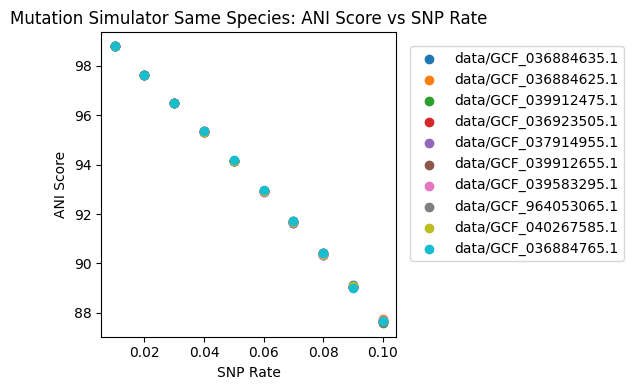

In [26]:
# Create a dictionary to store data by legend
data_dict = {}
for entry in ani_test_results:
    legend, x, y = entry
    if legend not in data_dict:
        data_dict[legend] = {'x': [], 'y': []}
    data_dict[legend]['x'].append(x)
    data_dict[legend]['y'].append(y)

# Plotting
plt.figure(figsize=(6, 4))

for legend, values in data_dict.items():
    # Scatter plot
    plt.scatter(values['x'], values['y'], label=legend)
    # Line plot to connect the dots
    #plt.plot(values['x'], values['y'], linestyle='-', marker='o')

plt.xlabel('SNP Rate')
plt.ylabel('ANI Score')
plt.title('Mutation Simulator Same Species: ANI Score vs SNP Rate')

# Adjust the legend to be outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)

plt.tight_layout()  # Adjust the layout so everything fits
plt.show()
